In [2]:
import torch
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')
import model
import data_setup
import utils
import os
import numpy as np
from matplotlib import pyplot


# Functions

In [3]:
import sklearn.metrics as skm

def classication_metrics_binary(y_true, y_pred_class):
    """
    Args:
      y_true: Ground truth (correct) labels.
      y_pred: Array of probability estimates provided by the model.

    Missing: AUPRC https://towardsdatascience.com/imbalanced-data-stop-using-roc-auc-and-use-auprc-instead-46af4910a494
    """
    # Compute accuracy
    acc = skm.accuracy_score(y_true, y_pred_class)
    balanced_acc = skm.balanced_accuracy_score(y_true, y_pred_class)
    # Compute precision
    # https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
    prec = skm.precision_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # Recall
    recall = skm.recall_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # F1
    f1 = skm.f1_score(y_true, y_pred_class, average="binary", zero_division=0.0)
    # Assign to list
    sensitivity = skm.recall_score(y_true , y_pred_class)
    specificity = skm.recall_score(np.logical_not(y_true) , np.logical_not(y_pred_class))
    gmeans = sqrt(sensitivity * specificity)

    print(f"""
    Accuracy: {acc:.3f} \n
    Balanced accuracy: {balanced_acc:.3f} \n
    F1: {f1:.3f} \n
    Precision: {prec:.3f} \n
    Recall: {recall:.3f} \n
    Sensitivity: {sensitivity:.3f} \n
    Specificity: {specificity:.3f} \n
    G-means: {gmeans:.3f} \n
    """)

    confusion_matrix = skm.confusion_matrix(y_true, y_pred_class)

    cm_display = skm.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    
    cm_display.plot()
    pyplot.show() 

# Noise detection

In [4]:
# load dataset
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [28]:
# Zip files and transforms
features = 'Combined'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_Combined.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_Combined.zip",
]
df_train_path = '/scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/Noise_detection/df_val_curated.csv'

In [29]:
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        None,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True,
        features=features
    )
train_dataloader, val_dataloader 

Grouping Pathology and physiology in one class

[0 0 1 ... 0 0 1]
tensor([3.3400e-05, 4.1098e-05])

Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2aabc65fac50>,
 <torch.utils.data.dataloader.DataLoader at 0x2aabc6867f40>)

## Trial 11
CNN_Long_Data2
Using dataframe: /scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv

Using zipfiles: ['/home/mcesped/scratch/Datasets/2048Hz/Dataset_Fnusa_Hilbert.zip', '/home/mcesped/scratch/Datasets/2048Hz/Dataset_Mayo_Hilbert.zip']

In [8]:
n_classes = 1
input_size = 1
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [9]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_11/best_model.pt"))

<All keys matched successfully>

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((10270,), (10270,))

In [12]:
y_pred_total

array([3.09198022e-01, 4.16526824e-01, 4.09560889e-01, ...,
       4.97195154e-01, 9.69519675e-01, 8.78338236e-04])

### Using ROC

In [13]:
from sklearn.metrics import roc_curve

In [14]:
testy = y_total
yhat = y_pred_total

Best Threshold=0.406050, G-Mean=0.820, Specificity=0.807, Sensitivity=0.834


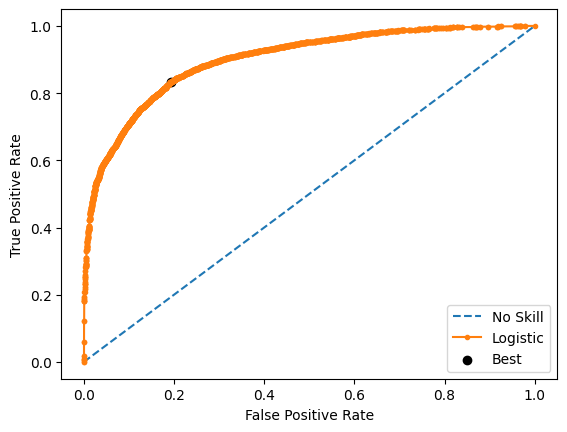

In [15]:
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### Using Prec-Recall curve

In [16]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

Best Threshold=0.396133, F-Score=0.814, Recall:0.845, Precision:0.785


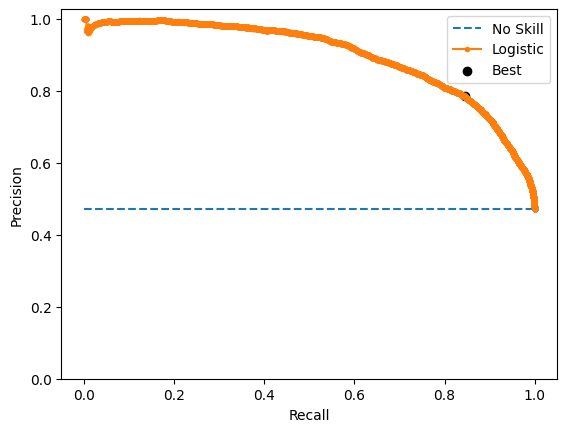

In [17]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

### Test both thresholds


    Accuracy: 0.820 

    Balanced accuracy: 0.820 

    F1: 0.813 

    Precision: 0.793 

    Recall: 0.834 

    Sensitivity: 0.834 

    Specificity: 0.807 

    G-means: 0.820 

    


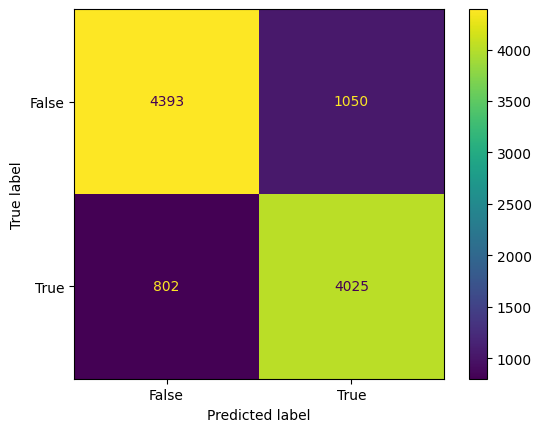

In [21]:
# ROC one
threshold_roc =  0.406050
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))


    Accuracy: 0.818 

    Balanced accuracy: 0.820 

    F1: 0.814 

    Precision: 0.784 

    Recall: 0.845 

    Sensitivity: 0.845 

    Specificity: 0.794 

    G-means: 0.819 

    


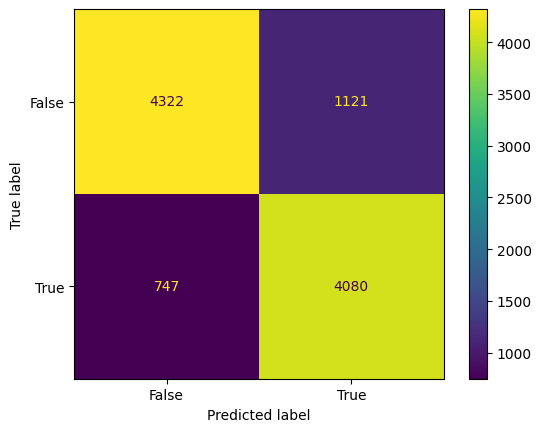

In [22]:
# Prec-recall one
threshold_f1 =  0.396133
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))


    Accuracy: 0.818 

    Balanced accuracy: 0.819 

    F1: 0.812 

    Precision: 0.787 

    Recall: 0.839 

    Sensitivity: 0.839 

    Specificity: 0.799 

    G-means: 0.819 

    


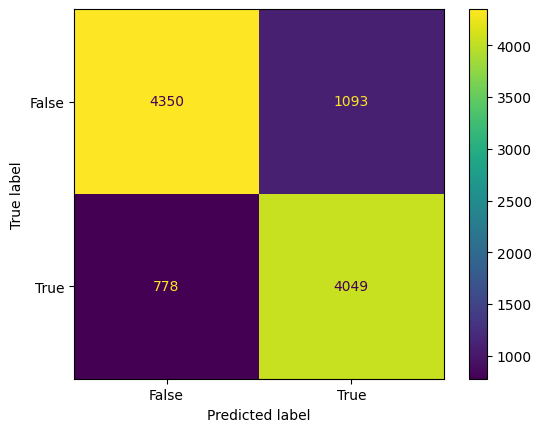

In [23]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))

## Trial 13
CNN_Long_Data2
Using dataframe: /scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv

Using zipfiles: ['/home/mcesped/scratch/Datasets/2048Hz/Dataset_Fnusa_Combined.zip', '/home/mcesped/scratch/Datasets/2048Hz/Dataset_Mayo_Combined.zip']

In [30]:
n_classes = 1
input_size = 2
model_0 = model.CNN_Long_Data2(n_classes=n_classes, input_size=input_size, input_length=6094)

In [31]:
model_0.load_state_dict(torch.load("/home/mcesped/scratch/code/NoiseDetection_iEEG/Reports/Noise_detection/2048Hz/trial_13/best_model.pt"))

<All keys matched successfully>

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
# Put model in eval mode
model_0.eval()
# Initiate values
y_total, y_pred_total = np.array([]), np.array([])

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(val_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model_0(X).squeeze()
        
        # Apply softmax
        y_pred_prob = torch.sigmoid(test_pred_logits)

        # Save results
        y_total = np.concatenate([y_total, y.detach().numpy()])
        y_pred_total = np.concatenate(
            [y_pred_total, y_pred_prob.detach().numpy()]
        )

y_total.shape, y_pred_total.shape

((10270,), (10270,))

### ROC

Best Threshold=0.359147, G-Mean=0.777, Specificity=0.854, Sensitivity=0.706


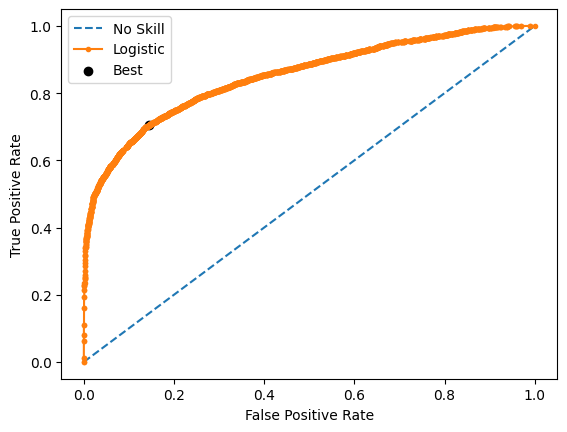

In [34]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

testy = y_total
yhat = y_pred_total

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f, Specificity=%.3f, Sensitivity=%.3f' % (thresholds[ix], gmeans[ix], 1-fpr[ix], tpr[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.785 

    Balanced accuracy: 0.780 

    F1: 0.755 

    Precision: 0.811 

    Recall: 0.706 

    Sensitivity: 0.706 

    Specificity: 0.854 

    G-means: 0.777 

    


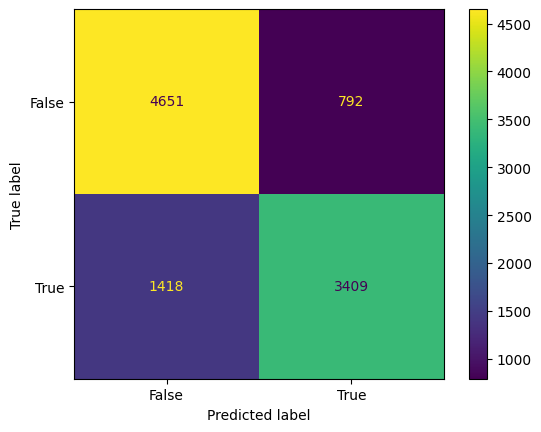

In [35]:
# ROC one
threshold_roc =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_roc).astype(int))

### F1 curve

Best Threshold=0.275257, F-Score=0.759, Recall:0.785, Precision:0.735


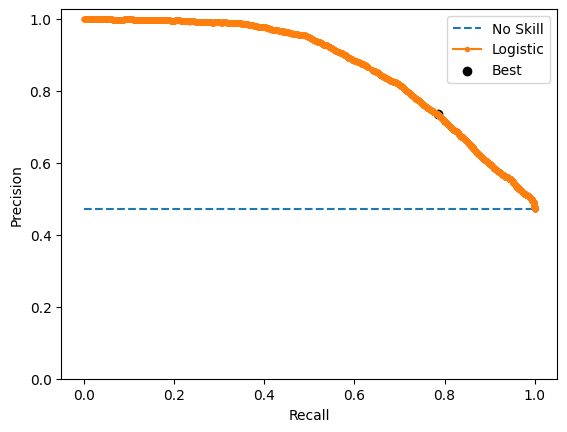

In [36]:
from sklearn.metrics import precision_recall_curve

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print(f'Best Threshold=%f, F-Score=%.3f, Recall:%.3f, Precision:%.3f' % (thresholds[ix], fscore[ix], recall[ix], precision[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.yticks(np.arange(0, 1.2, 0.2))
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


    Accuracy: 0.766 

    Balanced accuracy: 0.767 

    F1: 0.759 

    Precision: 0.735 

    Recall: 0.785 

    Sensitivity: 0.785 

    Specificity: 0.749 

    G-means: 0.767 

    


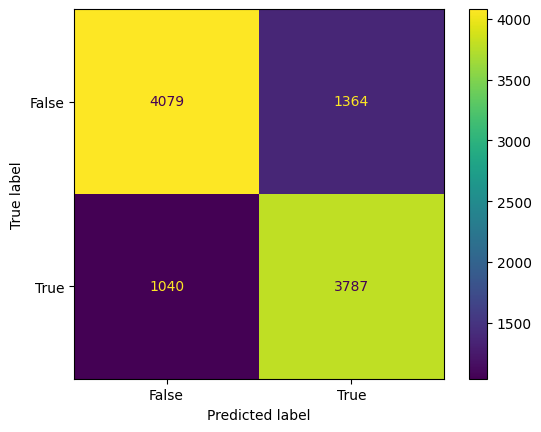

In [37]:
# Prec-recall one
threshold_f1 =  thresholds[ix]
classication_metrics_binary(testy, (yhat > threshold_f1).astype(int))

### Optimal threshold


    Accuracy: 0.775 

    Balanced accuracy: 0.774 

    F1: 0.757 

    Precision: 0.770 

    Recall: 0.745 

    Sensitivity: 0.745 

    Specificity: 0.802 

    G-means: 0.773 

    


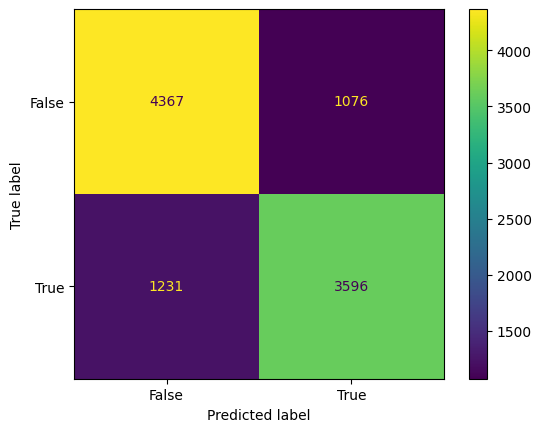

In [38]:
# Average
threshold_av = (threshold_f1+threshold_roc)/2
classication_metrics_binary(testy, (yhat > threshold_av).astype(int))